# Introduction
In this laboratory we will get our hands dirty working with Large Language Models (e.g. GPT and BERT) to do various useful things. I you haven't already, it is highly recommended to:

+ Read the [Attention is All you Need](https://arxiv.org/abs/1706.03762) paper, which is the basis for all transformer-based LLMs.
+ Watch (and potentially *code along*) with this [Andrej Karpathy video](https://www.youtube.com/watch?v=kCc8FmEb1nY) which shows you how to build an autoregressive GPT model from the ground up.

# Exercise 1: Warming Up
In this first exercise you will train a *small* autoregressive GPT model for character generation (the one used by Karpathy in his video) to generate text in the style of Dante Aligheri. Use [this file](https://archive.org/stream/ladivinacommedia00997gut/1ddcd09.txt), which contains the entire text of Dante's Inferno (**note**: you will have to delete some introductory text at the top of the file before training). Train the model for a few epochs, monitor the loss, and generate some text at the end of training. Qualitatively evaluate the results

In [1]:
import pathlib as pl
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F

from data_loader.swag_datamodule import SWAGDataModule
from data_loader.feature_datamodule import FeatureDataModule
from feature_extraction import extract_features

from models import QAMLP
from models.gpt import decode, estimate_loss, get_batch, GPTLanguageModel

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
max_iters = 500
eval_interval = 100
learning_rate = 3e-4

checkpoint_path = 'runs/nanogpt/gpt.pth'

print(f"Using device: {device}")

model = GPTLanguageModel()
model = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

Using device: cuda
10.783546 M parameters


In [3]:
if pl.Path(checkpoint_path).exists():
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint)
    print(f"Loaded checkpoint from {checkpoint_path}")

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss(model)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# overwrite the checkpoint
torch.save(model.state_dict(), checkpoint_path)

Loaded checkpoint from runs/nanogpt/gpt.pth
step 0: train loss 1.7579, val loss 1.8074
step 100: train loss 1.6759, val loss 1.7364
step 200: train loss 1.5785, val loss 1.6650
step 300: train loss 1.4732, val loss 1.6043
step 400: train loss 1.3904, val loss 1.5724
step 499: train loss 1.2913, val loss 1.5445


In [4]:
# generate from the model
model.load_state_dict(torch.load('runs/nanogpt/gpt.pth'))
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))
#open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))


E che 'l botta` d'io mai poco altedesmo;
  paro` che' idia ma l'ospeta e 'l diviola.

Quel l'e` quasi unl'alla sempo sco,
  tecesser nia la bolle di ben Stese,
  fiati suoleta de lor mano i calde.

Noi gido` che fate d'io le seguante,
  con la` d'occh'l penti foco scia ' lieto;
  e ch'ancosi` per stiglier de l'ittrossia.

I' me, ch'a piu` toffestiro dirsi,
  e desssu prianzi fierati il liro,
  tanno poi che nosti sanza fonti:

ch'ebber di reperosso e iolti arebbia
  vannor misini ornivi unos in 


We can see that after 1000 steps text stats to resemble the style of Divina Commedia, even though the words used aren't real. Some relationships, like angular brackets for citations and the title of the "Canto" are also learned.

# Exercise 2: Working with Real LLMs

Our toy GPT can only take us so far. In this exercise we will see how to use the [Hugging Face](https://huggingface.co/) model and dataset ecosystem to access a *huge* variety of pre-trained transformer models.

## Exercise 2.1: Installation and text tokenization

First things first, we need to install the [Hugging Face transformer library](https://huggingface.co/docs/transformers/index):

    conda install -c huggingface -c conda-forge transformers
    
The key classes that you will work with are `GPT2Tokenizer` to encode text into sub-word tokens, and the `GPT2LMHeadModel`. **Note** the `LMHead` part of the class name -- this is the version of the GPT2 architecture that has the text prediction heads attached to the final hidden layer representations (i.e. what we need to **generate** text). 

Instantiate the `GPT2Tokenizer` and experiment with encoding text into integer tokens. Compare the length of input with the encoded sequence length.

**Tip**: Pass the `return_tensors='pt'` argument to the togenizer to get Pytorch tensors as output (instead of lists).

In [6]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# import tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2',return_tensors='pt',padding_side='left')
# define model backbone
model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

c:\Users\Dario\mambaforge\envs\nlp\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Dario\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


GPT uses a **BPE tokenizer**, which is a subword-based tokenizer that allows to bring a good balance between character-level and word-level tokenizers, representing most common words as single tokens and rarer words as sequences of subword units.

To see this in action, let's try to encode the following sentence:

    "The quick brown fox jumps over the lazy dog"

In [7]:
input = 'The quick brown fox jumps over the lazy dog'

input_ids = tokenizer.encode(input)
print(input_ids)
print(tokenizer.convert_ids_to_tokens(input_ids))

[464, 2068, 7586, 21831, 18045, 625, 262, 16931, 3290]
['The', 'Ġquick', 'Ġbrown', 'Ġfox', 'Ġjumps', 'Ġover', 'Ġthe', 'Ġlazy', 'Ġdog']


We can see that some words are encoded with more than one token. All tokens containing the first word piece are preceded by the character Ġ

## Exercise 2.2: Generating Text

There are a lot of ways we can, given a *prompt* in input, sample text from a GPT2 model. Instantiate a pre-trained `GPT2LMHeadModel` and use the [`generate()`](https://huggingface.co/docs/transformers/v4.27.2/en/main_classes/text_generation#transformers.GenerationMixin.generate) method to generate text from a prompt.

**Note**: The default inference mode for GPT2 is *greedy* which might not results in satisfying generated text. Look at the `do_sample` and `temperature` parameters.

### Greedy search
In greedy search we always pick the token with the highest probability as the next token. This strategy can lead to repetitive and not very interesting text, as we can see in the following example.

In [8]:
# encode context the generation is conditioned on
# don't pass anything
#input = tokenizer.bos_token

input_ids = tokenizer.encode(input, return_tensors='pt')

output = model.generate(input_ids, max_length=128)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
The quick brown fox jumps over the lazy dog and runs off.

"I'm sorry, I'm sorry, I'm sorry," the fox says.

"I'm sorry, I'm sorry, I'm sorry," the fox says.

"I'm sorry, I'm sorry, I'm sorry," the fox says.

"I'm sorry, I'm sorry, I'm sorry," the fox says.

"I'm sorry, I'm sorry, I'm sorry," the fox says.

"I'm sorry, I'm sorry, I'm sorry," the fox says.



### Multinomial sampling
In multinomial sampling we randomly select the next token based on the probability distribution over the vocabulary. This allows to generate more diverse text, sampling less probable tokens. To perform multinomial sampling we set the `do_sample` parameter.

We can control the diversity of the sampling by using the `temperature` parameter. A low temperature will result in a more conservative sampling, while a high temperature will result in a more diverse sampling.

In [13]:
output = model.generate(input_ids,temperature=0.9,do_sample=True,max_length=512)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
The quick brown fox jumps over the lazy dog and runs his paws along his body. The lazy dog keeps his head down and he waits for the fox to run his paws at him. I don't want to be done with the dog. I wish he wouldn't run around on his little paws. The fox comes to rest between the lazy dog and my little fox and he looks at the other dog and says, "I'm a puppy". The lazy dog starts to run away from me and I take my leave and go to sleep somewhere. I want to go home, but I don't have to sleep. This is the truth of life or at least, the truth of my life.

Sometimes times I really want to sleep, because I'm so sad. My mother took me to a very long time after school and told me to wait for a while. I thought it would take all of my willpower to wait for a little bit more. This seems the answer to all my worries. I always say to myself, "Maybe I'll come back a little later then". I sa

By lowering the temperature, we can see that the text becomes more repetitive

In [9]:
output = model.generate(input_ids,temperature=0.1,do_sample=True, max_length=128)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
The quick brown fox jumps over the lazy dog and runs off.

The lazy dog runs off.

The lazy dog runs off.

The lazy dog runs off.

The lazy dog runs off.

The lazy dog runs off.

The lazy dog runs off.

The lazy dog runs off.
 seafood

The lazy dog runs off.

The lazy dog runs off.

The lazy dog runs offtch

The lazy dog runs off.

The lazy dog runs off.

The lazy dog runs off.

The lazy dog runs off.



### Beam search
In beam search we keep several sequence hypotheses at each time step, and eventually choose the one with the overall highest probability for the entire sequence. This has the advantage of identifying high-probability sequences that are not necessarily the most probable at each step. To perform beam search we set the `num_beams` parameter.

We can also combine the beam search with multinomial sampling by setting the `do_sample` parameter.

In [11]:
output = model.generate(input_ids, num_beams=5, temperature=0.9,do_sample=True, max_length=128)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
The quick brown fox jumps over the lazy dog and starts to run.

"Hey, look at that!"

The lazy dog starts running.

"Hey, look at that!"

The lazy dog starts running.

"Hey, look at that!"

The lazy dog starts running.


Another way to avoid repetitions is to use the `no_repeat_ngram_size` parameter, which prevents the model from generating the same n-gram twice.

In [15]:
output = model.generate(input_ids, num_beams=5, temperature=0.9,do_sample=True, no_repeat_ngram_size=3, max_length=128)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
The quick brown fox jumps over the lazy dog and runs off.

"I'm not going to let you go," she says. "I'm going to tell you to get out of here."


# Exercise 3: Reusing Pre-trained LLMs (choose one)

Choose **one** of the following exercises (well, *at least* one). In each of these you are asked to adapt a pre-trained LLM (`GPT2Model` or `DistillBERT` are two good choices) to a new Natural Language Understanding task. A few comments:

+ Since GPT2 is a *autoregressive* model, there is no latent space aggregation at the last transformer layer (you get the same number of tokens out that you give in input). To use a pre-trained model for a classification or retrieval task, you should aggregate these tokens somehow (or opportunistically select *one* to use).

+ BERT models (including DistillBERT) have a special [CLS] token prepended to each latent representation in output from a self-attention block. You can directly use this as a representation for classification (or retrieval).

+ The first *two* exercises below can probably be done *without* any fine-tuning -- that is, just training a shallow MLP to classify or represent with the appropriate loss function.

## Exercise 3.1: Training a Text Classifier (easy)

Peruse the [text classification datasets on Hugging Face](https://huggingface.co/datasets?task_categories=task_categories:text-classification&sort=downloads). Choose a *moderately* sized dataset and use a LLM to train a classifier to solve the problem.

**Note**: A good first baseline for this problem is certainly to use an LLM *exclusively* as a feature extractor and then train a shallow model.

### Irony detection on tweet-eval

[![WandB report](https://img.shields.io/badge/Weights_&_Biases-FFCC33?style=plastic&logo=WeightsAndBiases&logoColor=black)]()

Humor is a difficult concept. GPT-4 can [explain jokes](./images/gpt4-jokes.png), even if it takes all the fun out of them in the process.

Let's see if we can train a simple model to detect ironic tweets. We will use the [tweet-eval irony susbset](https://huggingface.co/datasets/tweet_eval/viewer/irony/train?p=0) from 🤗 Datasets.

This dataset is already split into train, validation and test sets, with 2.86k training samples, 784 validation samples and 955 test samples. Each sample is a tweet with a label indicating whether the tweet is ironic or not.

The dataset is already preprocessed, stripping out mentions and URLs. Emojis are kept as tokens.

We will use the `distilbert-base-uncased` model, which is a smaller version of the BERT model. We will use the 🤗 Transformers library to load the model and the tokenizer.

In [2]:
from datasets import load_dataset

dataset = load_dataset('tweet_eval', 'irony')

train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

BATCH_SIZE = 32

print(train_data[0])

Found cached dataset tweet_eval (C:/Users/Dario/.cache/huggingface/datasets/tweet_eval/irony/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


  0%|          | 0/3 [00:00<?, ?it/s]

{'text': 'seeing ppl walking w/ crutches makes me really excited for the next 3 weeks of my life', 'label': 1}


It is useful to know some rough statistics about the length of each sentence in the dataset, in order to choose the maximum length of the input sequence for the tokenizer, and evaluate if we need to truncate some sentences.
In this case, the maximum length is 177 words, but the mean is 14, and by setting the maximum length to 30 we can cover 95% of the sentences without truncation, while lowering a bit the memory usage.

In [3]:
all_lengths = []

for split in [train_data, val_data, test_data]:
    for item in split:
        all_lengths.append(len(item['text'].split()))

print(f"Max length: {max(all_lengths)}")
print(f"Min length: {min(all_lengths)}")
print(f"Mean length: {sum(all_lengths) / len(all_lengths)}")
print(f"Standard deviation: {np.std(all_lengths)}")

Max length: 177
Min length: 1
Mean length: 13.732884155618343
Standard deviation: 6.379859818821617


In [4]:
from data_loader import TweetEvalDataModule

te_dm = TweetEvalDataModule(model_name_or_path="distilbert-base-uncased", task_name="irony",max_seq_length=30, train_batch_size=BATCH_SIZE, eval_batch_size=BATCH_SIZE)

te_dm.prepare_data()
te_dm.setup("fit")

te_train_dl,te_val_dl = te_dm.train_dataloader(),te_dm.val_dataloader()

Found cached dataset tweet_eval (C:/Users/Dario/.cache/huggingface/datasets/tweet_eval/irony/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset tweet_eval (C:/Users/Dario/.cache/huggingface/datasets/tweet_eval/irony/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\Dario\.cache\huggingface\datasets\tweet_eval\irony\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343\cache-27298fa162cbec90.arrow
Loading cached processed dataset at C:\Users\Dario\.cache\huggingface\datasets\tweet_eval\irony\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343\cache-cba6f32e375d5951.arrow


Map:   0%|          | 0/955 [00:00<?, ? examples/s]

c:\Users\Dario\mambaforge\envs\nlp\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


### Model

We employed a pre-trained [DistilBERT](https://arxiv.org/pdf/1910.01108.pdf) model from HuggingFace's Transformers library.
DistilBERT is a distilled version of BERT, with 40% less parameters than BERT-base, and runs 60% faster while preserving over 95% of BERT's performances, mneasuered on GLUE language understanding benchmark. 
We will use this model as a feature extractor, and we will train a shallow MLP to perform a classification task.

In [5]:
from transformers import AutoModel
model = AutoModel.from_pretrained("distilbert-base-uncased")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
for batch in te_train_dl:
    batch = {k:v.squeeze() for k,v in batch.items()}
    print({k:v.shape for k,v in batch.items()})
    label = batch.pop("label")

    out = model(**batch)
    break

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_ids': torch.Size([32, 30]), 'attention_mask': torch.Size([32, 30]), 'label': torch.Size([32])}


In [3]:
dm = FeatureDataModule('./data','tweet_eval',BATCH_SIZE,num_workers=6,pin_memory=True)

dm.prepare_data()
dm.setup("fit")

train_dl,valid_dl = dm.train_dataloader(), dm.val_dataloader()

In [4]:
from models import MLP

LEARNING_RATE = 1e-3
CRITERION = "BCELoss"
EPOCHS = 20

model = MLP(num_classes=1,input_size=768,hidden_size=256,criterion=CRITERION,learning_rate=LEARNING_RATE)

from lightning import Trainer
trainer = Trainer(max_epochs=EPOCHS, devices=1, logger=False,enable_checkpointing=False)
trainer.fit(model, train_dl, valid_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type           | Params
----------------------------------------------
0 | classifier | Sequential     | 197 K 
1 | criterion  | BCELoss        | 0     
2 | train_acc  | BinaryAccuracy | 0     
3 | valid_acc  | BinaryAccuracy | 0     
----------------------------------------------
197 K     Trainable params
0         Non-trainable params
197 K     Total params
0.788     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


## Exercise 3.2: Training a Question Answering Model (harder)

Peruse the [multiple choice question answering datasets on Hugging Face](https://huggingface.co/datasets?task_categories=task_categories:multiple-choice&sort=downloads). Chose a *moderately* sized one and train a model to answer contextualized multiple-choice questions. You *might* be able to avoid fine-tuning by training a simple model to *rank* the multiple choices (see margin ranking loss in Pytorch).

### SWAG Dataset

[![WandB report](https://img.shields.io/badge/Weights_&_Biases-FFCC33?style=plastic&logo=WeightsAndBiases&logoColor=black)](https://api.wandb.ai/links/dla-darcio/25op1oeh)

We chose the [SWAG](https://huggingface.co/datasets/swag) dataset for this task.

The dataset is composed by 113k passages(73k training, 20k validation, 20k test),with four answer choices about what might happen next in the scene. The correct answer is the (real) video caption for the next event in the video; the three incorrect answers are adversarially generated and human verified, so as to fool machines but not humans. SWAG aims to be a benchmark for evaluating grounded commonsense NLI and for learning representations. 

<!-- Another dataset I explored is [RACE](https://huggingface.co/datasets/race) dataset. -->
<!-- The dataset is composed by 28K passages, and nearly 100K questions collected from English examinations in China, designed for middle and high school students. -->



In [2]:
from datasets import load_dataset

dataset = load_dataset("swag","regular")

# hyperparameters
BATCH_SIZE = 32

Found cached dataset swag (C:/Users/Dario/.cache/huggingface/datasets/swag/regular/0.0.0/9640de08cdba6a1469ed3834fcab4b8ad8e38caf5d1ba5e7436d8b1fd067ad4c)


  0%|          | 0/3 [00:00<?, ?it/s]


Each sample is composed by a complete sentence, the start of the next sentence and four possible continuations. Only one of them is the right one.

In [2]:
train_data = dataset['train']
val_data = dataset['validation']
print("Train dataset length:", len(train_data))

Train dataset length: 73546


Let's print an example from the training set.

In [3]:
endings = ['ending0', 'ending1', 'ending2', 'ending3']
row = val_data[0]
# print(row)
print(f"CONTEXT: {row['startphrase']}")
for i, c in enumerate(endings):
    print(f"ENDING: {i}: {row[c]}")
print(f"CORRECT: {row['label']}")

CONTEXT: Students lower their eyes nervously. She
ENDING: 0: pats her shoulder, then saunters toward someone.
ENDING: 1: turns with two students.
ENDING: 2: walks slowly towards someone.
ENDING: 3: wheels around as her dog thunders out.
CORRECT: 2


As done in the previous exercise, let's see some statistics about the length of the sentences in the dataset. The maximum length is 101 words, but the mean is 14, and by setting again the maximum length to 30 we can cover 95% of the sentences without truncation, while lowering a bit the memory usage.

Average length of startphrase: 14.06
Standard deviation of startphrase: 6.74
Max length of startphrase: 101
Min length of startphrase: 4


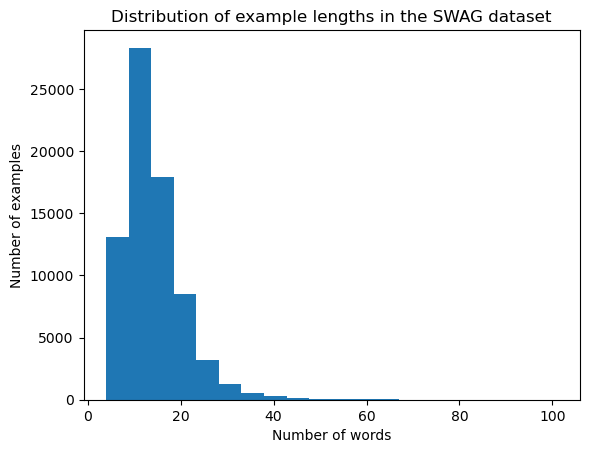

In [4]:
import numpy as np
lengths = list(map(lambda x: len(x.split()),train_data['startphrase']))
print(f"Average length of startphrase: {np.mean(lengths):.2f}")
print(f"Standard deviation of startphrase: {np.std(lengths):.2f}")
print("Max length of startphrase:", np.max(lengths))
print("Min length of startphrase:", np.min(lengths))


import matplotlib.pyplot as plt
plt.hist(lengths, bins=20)
plt.xlabel("Number of words")
plt.ylabel("Number of examples")
plt.title("Distribution of example lengths in the SWAG dataset")
plt.show()

### Preprocessing

To feed these samples to a model, we need to find an efficient encoding of the sentences. 
Our preprocessing pipeline will be composed by two steps:

1. Sentence construction: we will build sentence pairs formed by `sent1` and the concatenation of `sent2` and each of the four possible continuations. This means that we will obtain four difference sentence pairs for each sample.

2. Tokenization: we will encode each sentence pair using the tokenizer provided by the model. Between the two sentences we will add a special token `[SEP]`, which is used by the model to distinguish between the two sentences. We will also have a special token `[CLS]` at the beginning of the first sentence, which contains the representation of the entire sentence pair. To build batches, we will pad each sample to the maximum length of the batch, adding the special token `[PAD]`.

### ⚡Lightning DataModules 

To keep code tidy and improve experiment repeatability, I used⚡Lightning's `LightningDataModule` to define the dataset, perform  preprocessing and the dataloaders. 
The `prepare_data` method is used to download the dataset and the Tokenizer, while the `setup` method is used to split the dataset into train, validation and test sets and perform preprocessing, tokenization and encoding.

The processed dataset is composed by the following fields:
- `input_ids`: tokenized and encoded text (context + question + options)
- `attention_mask`: attention mask to avoid performing attention on padding tokens
- `label`: index of the correct answer

In [25]:
swag_dm = SWAGDataModule("distilbert-base-uncased","regular",30,BATCH_SIZE,BATCH_SIZE)
swag_dm.prepare_data()
swag_dm.setup("fit")

swag_train_dl,swag_valid_dl = swag_dm.train_dataloader(), swag_dm.val_dataloader()

Found cached dataset swag (C:/Users/Dario/.cache/huggingface/datasets/swag/regular/0.0.0/9640de08cdba6a1469ed3834fcab4b8ad8e38caf5d1ba5e7436d8b1fd067ad4c)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset swag (C:/Users/Dario/.cache/huggingface/datasets/swag/regular/0.0.0/9640de08cdba6a1469ed3834fcab4b8ad8e38caf5d1ba5e7436d8b1fd067ad4c)


  0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/73546 [00:00<?, ? examples/s]

c:\Users\Dario\mambaforge\envs\nlp\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Map:   0%|          | 0/20006 [00:00<?, ? examples/s]

Map:   0%|          | 0/20005 [00:00<?, ? examples/s]

In [29]:
for row in swag_valid_dl:
    for k,v in row.items():
        print(k,v.shape)

    input_ids = row['input_ids']
    attention_mask = row['attention_mask']
    labels = row.pop("label")

    print(swag_dm.tokenizer.decode(input_ids[4,3,:]))
    break

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


input_ids torch.Size([32, 4, 30])
attention_mask torch.Size([32, 4, 30])
label torch.Size([32])
[CLS] a man is in a bike shop and stand next to a bike while talking. [SEP] the man begins working out on his bike. [SEP] [PAD] [PAD]


### Model

As in previous exercise, we will use the DistilBERT model. One possible issue is that DistilBERT was not trained on the Next Sentence Prediction task during the distillation process, but it was shown in [RoBERTa](https://arxiv.org/pdf/1907.11692.pdf) paper that this task may not be necessary for Natural Language Inference tasks.

The MLP used for the downstream task is composed by two linear layers with ReLU activation and dropout. Since DistilBERT's hidden size is 768,  The first layer will have 768 input units and $d$ output units, while the second layer has $d$ input units and 1 output unit, with $d$ being a hyperparameter.
We chose $d=256$ in our experiments.



### Feature extraction

The output of the model is the computed hidden state, a 768-dimensional vector for each token in the input sequence. We will use the pooled representation, available in the initial `[CLS]` token as a representation of the entire input sequence. 
The pooled representation is computed by averaging the hidden states of the last four layers of the model by default.

We will pre-compute the hidden state for each sample in the dataset, and store in a file. This will speed up the training process, since we will not need to compute the hidden state for each sample at each epoch.
The pre-computed hidden states (1GB) and are available at this [link](https://drive.google.com/drive/folders/1vjHMx2viF16B2NrA7WKOPV8GbQb9s-M8?usp=sharing) 

You can re-compute the hidden states by running the following command:

```bash
python extract_features.py --model_name_or_path distilbert-base-uncased --max_seq_length 32 --batch_size <YOUR_BATCH_SIZE(default=32)>
```

In [31]:
dm = FeatureDataModule('./data','swag',BATCH_SIZE,num_workers=6,pin_memory=True)

dm.prepare_data()
dm.setup("fit")

train_dl,valid_dl = dm.train_dataloader(), dm.val_dataloader()

#### Classification setting 

The classifier is used to predict the probability of each answer choice to be the correct one. That mean that the model will evaluate the "correctness" of each value indipendently, without comparing the alternatives. 
The model is then trained with the cross entropy loss. I believe that this setting is simple, but it is harder to learn and to get a good performance.

Surprisingly, this is the approach also used in the HuggingFace implementation `DistilBertForMultipleChoice`. If you're curious, you can find the code [here](https://github.com/huggingface/transformers/blob/04f46a22d8b5f38c8369b3d995df3102b8d56dcd/src/transformers/models/distilbert/modeling_distilbert.py#L1033). This approach may scale badly to a higher number of alternatives, since the model will need to compute the probability of each alternative independently.

I define a custom dataset FeatureDataset to load the pre-computed hidden states and the labels. I suspect that the Dataloader approach is equivalent to split the tensor into batches and cycle through them, but I'll use the DataLoader approach.

An interesting alternative for classification could be to give to the MLP an input composed by the concatenation of the pooled representations of each alternative.

### Margin ranking loss
PyTorch's `MarginRankingLoss` is a loss function that aims to predict a relative distance between inputs. This task is called *Metric Learning*. It takes as input two inputs $x_1$ and $x_2$ and a label $y$ (containing 1 or -1).
- If $y=1$ then $x_1$ should be ranked higher
- Conversely, if $y=-1$ $x_2$ should have a higher value.

The loss function is defined as follows:

$$\text{loss}(x_1, x_2, y) = \max(0, -y * (x_1 - x_2) + \text{margin})$$

### Training


Training is performed by running the following script:

```bash
python main.py fit -c configs/YOUR_CONFIG_FILE.yaml
```

A list of configuration file is available in [configs](./configs/) folder.
Alternatively, here's a simplified training snippet:

In [33]:
LEARNING_RATE = 1e-3
CRITERION = "CrossEntropyLoss"
NUM_CHOICES = 4
EPOCHS = 20

model = QAMLP(num_choices=NUM_CHOICES,input_size=768,hidden_size=256,criterion=CRITERION,learning_rate=LEARNING_RATE)

from lightning import Trainer
trainer = Trainer(max_epochs=EPOCHS, devices=1, logger=False,enable_checkpointing=False)
trainer.fit(model, train_dl, valid_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | classifier | Sequential         | 197 K 
1 | criterion  | CrossEntropyLoss   | 0     
2 | train_acc  | MulticlassAccuracy | 0     
3 | valid_acc  | MulticlassAccuracy | 0     
--------------------------------------------------
197 K     Trainable params
0         Non-trainable params
197 K     Total params
0.788     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


### Evaluation

A detailed report is available on [WandB](https://wandb.ai//dla-darcio/lab-2-question-answering/reports/Multiple-Choice-Question-Answering--Vmlldzo0NzY0MTM3)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


students lower their eyes nervously. she pats her shoulder, then saunters toward someone.
students lower their eyes nervously. she turns with two students.
students lower their eyes nervously. she walks slowly towards someone.
students lower their eyes nervously. she wheels around as her dog thunders out.
CORRECT: 2
Features shape: torch.Size([32, 4, 768])
PREDICTED: 0


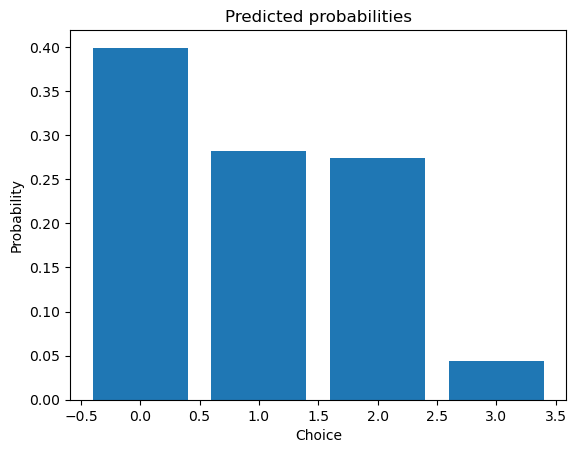

In [50]:
bert = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
bert.eval()

for batch in swag_valid_dl:

    decoded_text = swag_dm.tokenizer.batch_decode(batch['input_ids'][0],skip_special_tokens=True)

    for i in range(4):
        print(decoded_text[i])
    print(f"CORRECT: {batch['label'][0]}")

    features, labels = extract_features(bert,device=device,batch=batch)

    print(f"Features shape: {features.shape}")

    logits = model(features)

    probs = nn.functional.softmax(logits, dim=1)

    print(f"PREDICTED: {torch.argmax(logits[0,:])}")

    plt.bar(np.arange(4), probs[0,:].detach().cpu().numpy())
    plt.xlabel("Choice")
    plt.ylabel("Probability")
    plt.title("Predicted probabilities")
    plt.show()
    break

## Exercise 3.3: Training a Retrieval Model (hardest)

The Hugging Face dataset repository contains a large number of ["text retrieval" problems](https://huggingface.co/datasets?task_categories=task_categories:text-retrieval&p=1&sort=downloads). These tasks generally require that the model measure *similarity* between text in some metric space -- naively, just a cosine similarity between [CLS] tokens can get you pretty far. Find an interesting retrieval problem and train a model (starting from a pre-trained LLM of course) to solve it.

**Tip**: Sometimes identifying the *retrieval* problems in these datasets can be half the challenge. [This dataset](https://huggingface.co/datasets/BeIR/scifact) might be a good starting point.

## References

- [HuggingFace Transformers](https://huggingface.co/transformers/)
- [HuggingFace Datasets](https://huggingface.co/datasets)
- [PyTorch Lightning](https://www.pytorchlightning.ai/)
- [PyTorch Lightning Trainer](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html)
- [PyTorch Lightning LightningDataModule](https://pytorch-lightning.readthedocs.io/en/latest/extensions/datamodules.html)